# Interactive Example

## 1. Run GaMMA in terminal or use QuakeFlow API

Note: Please only use the QuakeFlow API for debugging and testing on small datasets. Do not run large jobs using the QuakeFlow API. The computational cost can be high for us.

```bash
uvicorn --app-dir=gamma app:app --reload --port 8002
```

In [1]:
import requests
import json
import pandas as pd
import os

In [4]:
GAMMA_API_URL = "http://127.0.0.1:8002"
#GAMMA_API_URL = "http://test.quakeflow.com:8002"

## 2. Prepare test data

- Download test data: PhaseNet picks of the 2019 Ridgecrest earthquake sequence
1. picks file: picks.json
2. station information: stations.csv
3. events in SCSN catalog: events.csv
4. config file: config.pkl

```bash
wget https://github.com/wayneweiqiang/GMMA/releases/download/test_data/test_data.zip
unzip test_data.zip
```

In [5]:
data_dir = lambda x: os.path.join("test_data2", x)
station_csv = data_dir("stations.csv")
pick_json = data_dir("picks.json")
catalog_csv = data_dir("catalog_gamma.csv")
picks_csv = data_dir("picks_gamma.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

## set config
config = {'xlim_degree': [-118.004, -117.004], 
          'ylim_degree': [35.205, 36.205],
          'z(km)': [0, 41]}

## read stations
stations = pd.read_csv(station_csv, delimiter="\t")
stations = stations.rename(columns={"station":"id"})
stations_json = json.loads(stations.to_json(orient="records"))

## read picks
picks = pd.read_json(pick_json).sort_values("timestamp").iloc[:500]
picks["timestamp"] = picks["timestamp"].apply(lambda x: x.isoformat(timespec='milliseconds'))
picks_json = json.loads(picks.to_json(orient="records"))

## run association
result = requests.post(f"{GAMMA_API_URL}/predict", json= {
                                    "picks":picks_json, 
                                    "stations":stations_json,
                                    "config": config
                                    })

result = result.json()
# catalog_gamma = json.loads(result["catalog"])
# picks_gamma = json.loads(result["picks"])
catalog_gamma = result["catalog"]
picks_gamma = result["picks"]

## show result
print("GaMMA catalog:")
display(pd.DataFrame(catalog_gamma))
# print("GaMMA association:")
# display(pd.DataFrame(picks_gamma))

GaMMA catalog:


,time,x(km),y(km),z(km),magnitude,sigma_time,sigma_amp,cov_time_amp,event_index,gamma_score,longitude,latitude,depth(m)
0,2019-07-04T17:02:54.965,0.927462,0.537216,17.024162,4.350403,0.316631,0.328228,0.048223,1,98.000000,-117.493751,35.709841,17024.161537
1,2019-07-04T17:04:02.622,-0.746127,-0.045816,13.787968,2.049310,0.276628,0.453068,0.091550,2,33.000000,-117.512245,35.704587,13787.967544
2,2019-07-04T17:05:05.417,0.095600,0.688582,12.118556,1.278982,0.424091,0.333425,0.166122,3,50.819299,-117.502944,35.711206,12118.556266
3,2019-07-04T17:05:47.939,-1.186084,0.517128,14.720376,0.603071,0.345556,0.457774,0.122753,4,17.000000,-117.517107,35.709660,14720.376393
4,2019-07-04T17:06:24.050,0.929194,0.540646,11.315478,0.737914,0.469510,0.443609,0.119703,5,44.957867,-117.493732,35.709872,11315.478225
5,2019-07-04T17:07:54.175,-11.263995,-4.591839,14.330100,-0.056150,0.307736,0.375926,0.056832,6,12.000000,-117.628402,35.663550,14330.100051
6,2019-07-04T17:08:26.502,1.089507,2.068398,10.148783,0.545266,0.757403,0.324765,0.094050,7,43.780089,-117.491958,35.723641,10148.782500
7,2019-07-04T17:08:52.131,3.343962,0.910351,9.483380,0.250136,0.114453,0.380923,0.005486,8,10.000000,-117.467046,35.713199,9483.379983
8,2019-07-04T17:09:19.720,1.100199,0.445305,16.688944,2.420881,0.305906,0.312775,0.027236,9,98.000000,-117.491842,35.709013,16688.943843


In [ ]:
print(result.text)

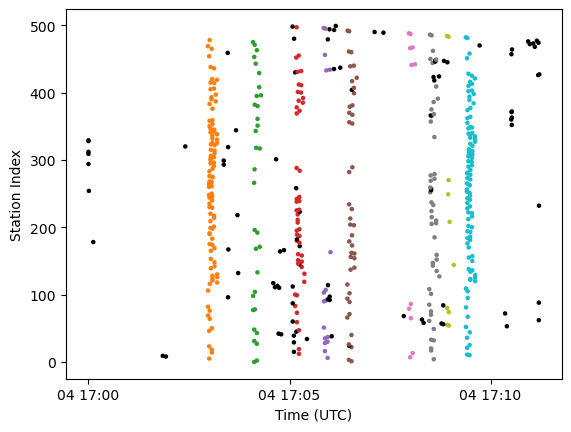

In [6]:
from datetime import datetime
import matplotlib.pyplot as plt
picks_gamma = pd.DataFrame(picks_gamma)
picks_gamma = picks_gamma.sort_values("id").reset_index(drop=True)
plt.figure()
plt.scatter(picks_gamma["timestamp"].apply(lambda x: datetime.fromisoformat(x)), picks_gamma.index, s=5, c=picks_gamma["event_index"].apply(lambda x: "k" if x==-1 else f"C{x}"))
plt.xlabel("Time (UTC)")
plt.ylabel("Station Index")
plt.show()